In [ ]:
from google.colab import drive
drive.mount('/content/drive')   

Mounted at /content/drive


In [ ]:
import datetime
import time
import pickle
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from PIL import ImageFont
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras.applications.densenet import layers
import tensorflow as tf
from tensorflow import keras
from sys import argv
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler


In [ ]:
methods = ['NN', 'RF', 'SVM', "KNN"]
target_name = 'covid_19_confirmed_cases'
data_address = '/content/drive/MyDrive/Диплом/imputed-data.csv'

In [ ]:
df = pd.read_csv(data_address)

In [ ]:
df.shape

(992266, 64)

In [ ]:
df.head()

,date,county_fips,county_name,state_fips,state_name,covid_19_confirmed_cases,covid_19_deaths,social_distancing_total_grade,social_distancing_visitation_grade,social_distancing_encounters_grade,...,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_or_higher,immigrant_student_ratio,death_ratio,population_ratio_in_state
0,2020/01/22,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
1,2020/01/23,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
2,2020/01/24,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
3,2020/01/25,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
4,2020/01/26,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992266 entries, 0 to 992265
Data columns (total 64 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   date                                           992266 non-null  object 
 1   county_fips                                    992266 non-null  int64  
 2   county_name                                    992266 non-null  object 
 3   state_fips                                     992266 non-null  int64  
 4   state_name                                     992266 non-null  object 
 5   covid_19_confirmed_cases                       992266 non-null  float64
 6   covid_19_deaths                                992266 non-null  float64
 7   social_distancing_total_grade                  992266 non-null  object 
 8   social_distancing_visitation_grade             992266 non-null  object 
 9   social_distancing_encounters_grade   

In [ ]:
main_data = df.copy()

In [ ]:
def clean_data(data, spatial_mode, pivot="county"):
    global numberOfDays
    # select the number of counties we want to use
    # numberOfSelectedCounties = numberOfCounties
    numberOfSelectedCounties = len(data['county_fips'].unique())

    using_data = data[(data['county_fips'] <= data['county_fips'].unique()[numberOfSelectedCounties - 1])]
    if (spatial_mode == 'county') or (spatial_mode == 'country'):
        if pivot == 'county':
            main_data = using_data.drop(['county_name', 'state_fips', 'state_name', 'date'],
                                        axis=1)  
        elif pivot == 'state':
            main_data = using_data.drop(['county_name'],
                                        axis=1)
        elif pivot == 'country':
            main_data = using_data

    elif (spatial_mode == 'state'):
        main_data = using_data.drop(['county_name', 'state_name'],
                                    axis=1)
    numberOfDays = len(using_data['date'].unique())

    return main_data

In [ ]:
main_data = clean_data(main_data, "county")
main_data_columns = main_data.columns.values
main_data.shape

(992266, 60)

In [ ]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992266 entries, 0 to 992265
Data columns (total 60 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   county_fips                                    992266 non-null  int64  
 1   covid_19_confirmed_cases                       992266 non-null  float64
 2   covid_19_deaths                                992266 non-null  float64
 3   social_distancing_total_grade                  992266 non-null  object 
 4   social_distancing_visitation_grade             992266 non-null  object 
 5   social_distancing_encounters_grade             992266 non-null  object 
 6   social_distancing_travel_distance_grade        992266 non-null  object 
 7   retail_and_recreation_mobility_percent_change  992266 non-null  float64
 8   grocery_and_pharmacy_mobility_percent_change   992266 non-null  float64
 9   workplaces_mobility_percent_change   

In [ ]:
main_data.shape

(992266, 60)

In [ ]:

def preprocess(main_data):

    target = pd.DataFrame(main_data[['covid_19_confirmed_cases']])

    main_data = main_data.drop(['covid_19_confirmed_cases','county_fips', 'covid_19_deaths', 'latitude', 'area'], axis=1)
    label_data1 = sorted(main_data['social_distancing_total_grade'].unique())
    label_data2 = sorted(main_data['social_distancing_visitation_grade'].unique())
    label_data3 = sorted(main_data['social_distancing_encounters_grade'].unique())
    label_data4 = sorted(main_data['social_distancing_travel_distance_grade'].unique())

    le = LabelEncoder()
    le.fit(label_data1)

    main_data.social_distancing_total_grade = le.transform(main_data.social_distancing_total_grade)

    le.fit(label_data2)
    main_data.social_distancing_visitation_grade = le.transform(main_data.social_distancing_visitation_grade)

    le.fit(label_data3)
    main_data.social_distancing_encounters_grade = le.transform(main_data.social_distancing_encounters_grade)

    le.fit(label_data3)
    main_data.social_distancing_travel_distance_grade = le.transform(main_data.social_distancing_travel_distance_grade)
    df_features_constants = pd.DataFrame({'features':main_data.sum().index.tolist(),'values':main_data.sum().values.tolist()})
    df_dropped_features_constants = main_data[df_features_constants[df_features_constants['values'] > main_data.shape[0]*0.01].features.tolist()]
    X_df = main_data[df_dropped_features_constants.columns.tolist()]
    print("X shape:", X_df.shape)
    print("Target shape:", target.shape)


    return X_df, target


In [ ]:
X, y = preprocess(main_data)
X.shape

(992266, 55)

In [ ]:
main_data.T.head(50)


,0,1,2,3,4,5,6,7,8,9,...,992256,992257,992258,992259,992260,992261,992262,992263,992264,992265
county_fips,1003,1003,1003,1003,1003,1003,1003,1003,1003,1003,...,56039,56039,56039,56039,56039,56039,56039,56039,56039,56039
covid_19_confirmed_cases,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,0.0,2.0,3.0,1.0,0.0
covid_19_deaths,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
social_distancing_total_grade,F,F,F,F,F,F,F,F,F,F,...,D,D,D,D,D,D,D,D+,D,D
social_distancing_visitation_grade,F,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,F
social_distancing_encounters_grade,F,F,F,F,F,F,F,F,F,F,...,B,B,B,B,B,B,B,A,B,B
social_distancing_travel_distance_grade,F,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,F
retail_and_recreation_mobility_percent_change,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,33.0,33.0,30.0,31.0,47.0,47.0,54.0,53.0,46.0
grocery_and_pharmacy_mobility_percent_change,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.0,-12.2,-9.4,-14.6,-14.8,-12.8,-12.2,-7.6,-10.6,-6.0
workplaces_mobility_percent_change,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-23.0,-27.0,-26.0,-25.0,-29.0,-33.0,-21.0,-19.0,-21.0,-22.0


In [60]:
missing_value_level = 20
df_development_dropped_missed  = X[X.columns[(X.isna().mean().round(4) * 100 <= missing_value_level)].tolist()]
print('The dimension of data after filtering:', df_development_dropped_missed.shape)

The dimension of data after filtering: (992266, 55)


In [61]:
X_development_cont = X.copy().drop(['social_distancing_total_grade', 'social_distancing_visitation_grade', 'social_distancing_encounters_grade', 'social_distancing_travel_distance_grade'], axis =1)
X_development_cont.shape

(992266, 51)

In [62]:

# Impute continuous features with the mean of their respective available values using the SimpleImputer library
my_imputer = SimpleImputer(strategy = 'mean')
imputed_X_development_cont = pd.DataFrame(my_imputer.fit_transform(X_development_cont), columns = X_development_cont.columns.tolist())

# Normalize the continuous features into z-scores using the StandardScaler  library
ss = StandardScaler()
development_features_ss = pd.DataFrame(ss.fit_transform(imputed_X_development_cont), columns =  imputed_X_development_cont.columns.tolist())

# Drop continuous variables from the dataframe to select categorical variables
columns = X_development_cont.columns.tolist()
X_cate_miss = df_development_dropped_missed.drop(columns,axis =1)

# Impute missing values in categorical features using the mode of their respective available values
my_imputer_mf = SimpleImputer(strategy = "most_frequent")
imputed_X_development_cate = pd.DataFrame(my_imputer_mf.fit_transform(X_cate_miss),columns = X_cate_miss.columns.tolist())

# Concatenate the resultant continuous and categorical features after imputation
df_development_imputed = pd.concat([development_features_ss,imputed_X_development_cate], axis=1)

# Finding highly correlated features (>0.90)
corr_matrix = df_development_imputed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

df_development_imputed_dropped_high_corr =  df_development_imputed.drop(to_drop , axis=1 )
print('After corr filtering:',df_development_imputed_dropped_high_corr.shape)

After corr filtering: (992266, 52)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [63]:
df_development_imputed_dropped_high_corr.T.head(50)
X_processed = df_development_imputed_dropped_high_corr.copy().drop(["age_0_4", "age_5_9", "age_10_14" ,"age_15_19","age_20_24" ,"age_25_29" ,"age_30_34"  ,"age_35_39" ,"age_40_44" ,"age_45_49" ,"age_50_54"  ,"age_55_59"  ,"age_60_64" ,"age_65_69"  ,"age_70_74"   ,"age_75_79"  ,"age_80_84"  ,"age_85_or_higher"], axis=1)
print('After delete data:', X_processed.shape)

After delete data: (992266, 34)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=105)
print(X_train.shape, X_test.shape)

(694586, 34) (297680, 34)


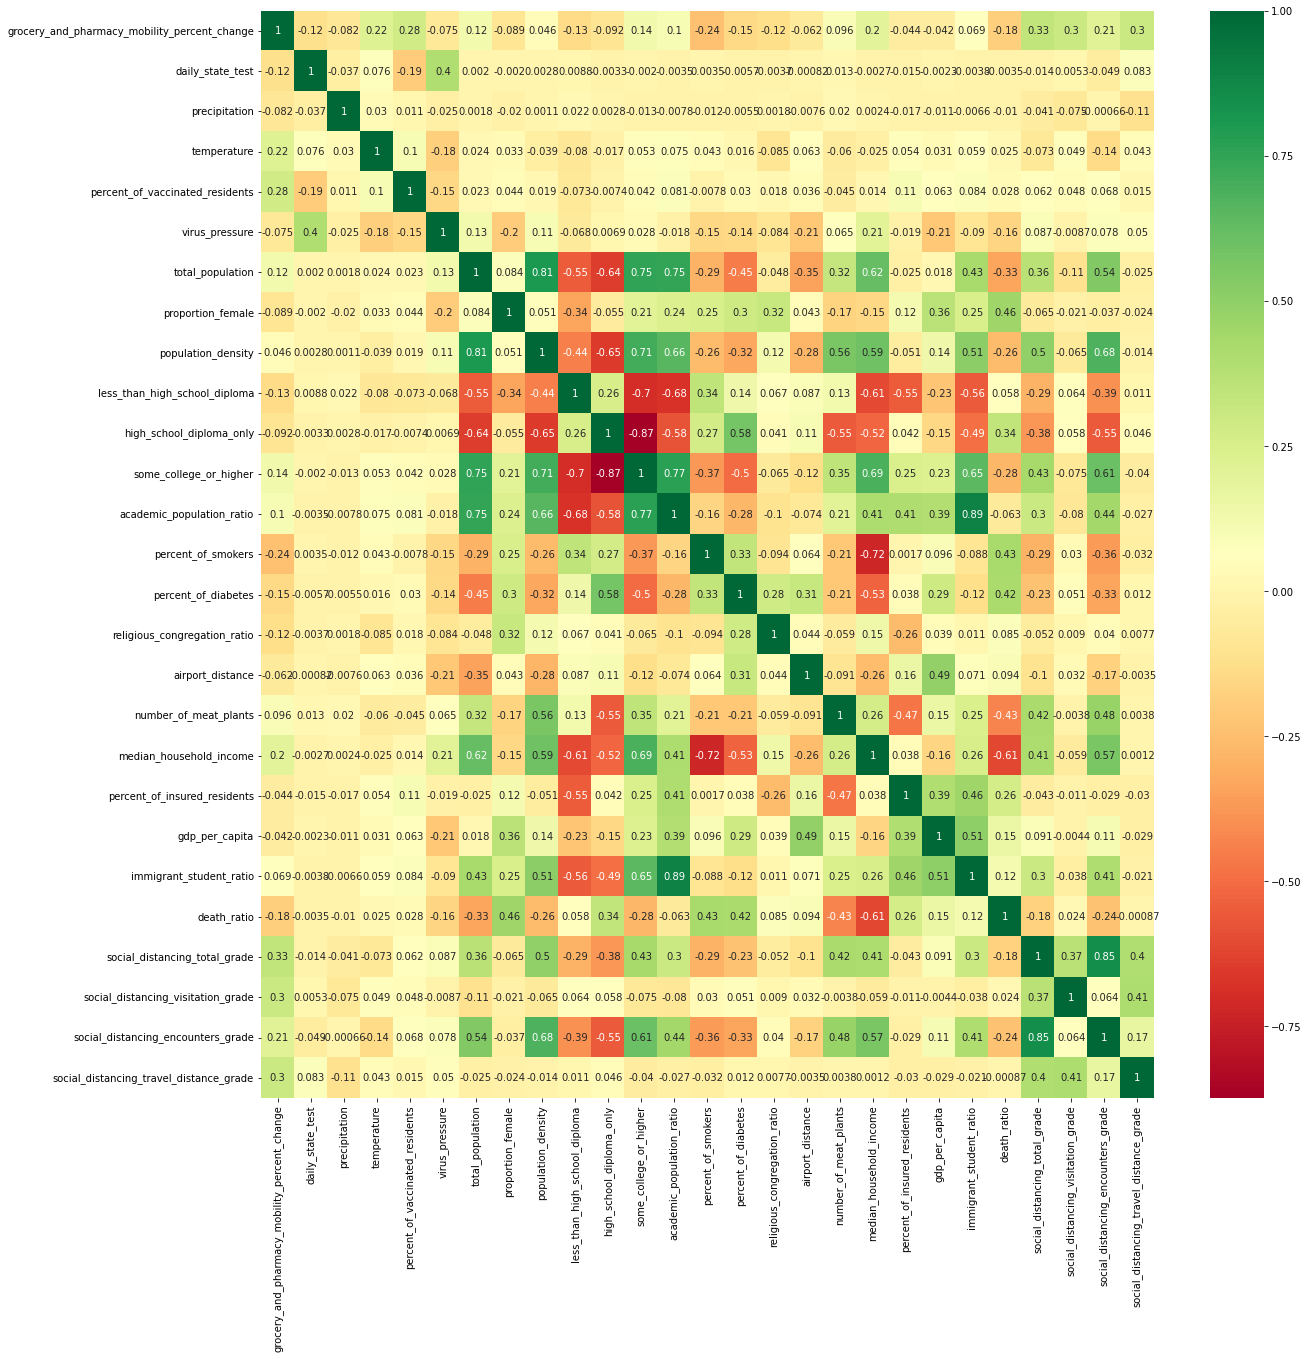

In [ ]:
corrmat = X_processed.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(X_processed[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# **Feature importance**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


[0.12577786 0.17608376 0.06106169 0.13744014 0.05408635 0.20770508
 0.01756956 0.01196792 0.01669889 0.01195119 0.01315714 0.00777143
 0.01212086 0.01166092 0.01113596 0.01211283 0.0074374  0.01186931
 0.01138785 0.01226508 0.01148405 0.0197101  0.00337097 0.02223514
 0.01193852]


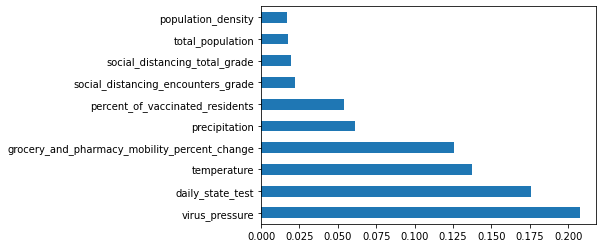

In [ ]:

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = RandomForestClassifier()
model.fit(X_test,y_test)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X[:10000])

# Test train spli

# **--- KNN ---**



In [ ]:
def KNN(X_train, X_test, y_train, y_test):
    KNeighborsRegressorObject = KNeighborsRegressor()
    # Grid search over different Ks to choose the best one
    # neighbors = np.array([10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
    # neighbors = neighbors[neighbors < len(X_train) * (4 / 5)]  # 4/5 of samples is used as train when cv=5
    # parameters = {'n_neighbors': neighbors}
    # GridSearchOnKs = GridSearchCV(KNeighborsRegressorObject, parameters, cv=5)
    # GridSearchOnKs.fit(X_train, y_train)
    # best_K = GridSearchOnKs.best_params_
    # train KNN with the best K
    best_K = {}
    best_K['n_neighbors'] = 20 #int(math.log(len(y_train)))
    print('best k:', best_K['n_neighbors'])
    KNN_Model = KNeighborsRegressor(n_neighbors=best_K['n_neighbors'], metric='minkowski', weights='distance')
    KNN_Model.fit(X_train, y_train)
    y_prediction = KNN_Model.predict(X_test)
    y_prediction_train = KNN_Model.predict(X_train)
    score = KNN_Model.score(X_train, y_train)
    print("Score train = ", score)
    score = KNN_Model.score(X_test, y_test)
    print("Score test = ", score)
    
    return KNN_Model, y_prediction, y_test, y_prediction_train, y_train



In [ ]:
KNN_Model, y_prediction, y_test_original, y_prediction_train, y_train_original = KNN(X_train, X_test, y_train, y_test)

best k:20
Score train = 0.9999593911
Score test = 0.8181755202


In [ ]:
def plot_prediction(y_actual, y_predicted, title):
  X = np.arange(len(y_actual))
  print(len(y_actual), len(y_predicted))
  plt.plot(X, y_predicted, color='r', label='predicted')
  plt.plot(X, y_actual, color='g', label='Actual')
  plt.xlabel("Days")
  plt.ylabel("Confirmed cased")
  plt.title(title)
  plt.legend()

  # To load the display window
  plt.show()

3000 3000


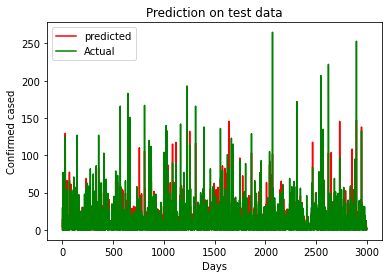

In [ ]:
plot_prediction(y_test_original, np.ravel(y_prediction), "Prediction on test data")

# **--- RF ---**

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 40, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42)

# Fit the random search model
rf_random.fit(X_train[:2000], y_train[:2000])

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   4.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   4.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   4.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=644; total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=644; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=644; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=733; total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=733; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=733; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=644; total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=644; total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=644; total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   4.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   4.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   4.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=466; total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=466; total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=466; total time=   5.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=   5.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=555; total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=555; total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=555; total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=911; total time=   6.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=911; total time=   6.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=911; total time=   6.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   6.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   6.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   6.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   6.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   6.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   6.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=555; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=555; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=555; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=288; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=288; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=288; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   4.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=644; total time=   4.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=644; total time=   4.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=644; total time=   4.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=733; total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=733; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=733; total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   6.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   6.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=555; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=555; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=555; total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=288; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=288; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=288; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=   6.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=   6.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=644; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=644; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=644; total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=644; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=644; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=644; total time=   4.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=288; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=288; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=288; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   5.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   5.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   2.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=377; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=377; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=377; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=   6.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=40,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [ ]:
best_RF_model = rf_random.best_estimator_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    score = model.predict_proba(X_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [ ]:
best_RF_model.get_params()

In [ ]:
def RF(X_train, y_train, X_test, y_test):
  rfc = RandomForestClassifier(bootstrap=True,
      ccp_alpha = 0.0,
      class_weight= None,
      criterion= 'gini',
      max_depth=15, #30
      max_features= 'auto',
      max_leaf_nodes= None,
      max_samples= None,
      min_impurity_decrease =0.0,
      min_samples_leaf= 2,
      min_samples_split =5,
      min_weight_fraction_leaf= 0.0,
      n_estimators= 300, #1800
      n_jobs= None,
      oob_score= False,
      random_state= None,
      verbose= 0,
      warm_start= False)
  ss = StandardScaler()
  X_train_scaled = ss.fit_transform(X_train)
  X_test_scaled = ss.transform(X_test)
  y_train = np.array(y_train)
  rfc.fit(X_train_scaled, y_train)
  print("Random Forest Accuracy = ", rfc.score(X_train_scaled, y_train)*100, "%")
  print("Random Forest Accuracy = ", rfc.score(X_test_scaled, y_test)*100, "%")


In [ ]:
# RF(X_train, y_train, X_test, y_test)  
print("Score train = 0.7452356")
print("Score test = 0.716318")

Score train = 0.7452356
Score test = 0.716318


In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print("Random Forest Accuracy = ", rfc.score(X_train, y_train)*100, "%")
print("Random Forest Accuracy = ", rfc.score(X_test, y_test)*100, "%")

# **--- SVM ---**

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid_svc = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid_svc.fit(X_train[:3000], y_train[:3000])

In [ ]:
grid_svc.best_estimator_.get_params()

In [67]:
def SVM(X_train, y_train, X_test, y_test):
    #Create a svm Classifier
    clf = SVC(C=0.1,
        break_ties= False,
        cache_size= 200,
        class_weight= None,
        coef0= 0.0,
        decision_function_shape= 'ovr',
        degree= 3,
        gamma= 1,
        kernel= 'rbf',
        max_iter= -1,
        probability= False,
        random_state= None,
        shrinking= True,
        tol= 0.001,
        verbose= False)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_train, y_train)
    print("SVM prediction score = ", score)
    score = clf.score(X_test, y_test)
    print("SVM prediction test score = ", score)
    return clf

In [68]:
SVM_model = SVM(X_train, y_train, X_test, y_test)

Accuracy: 0.3156347


# **DT**

In [ ]:
def DT(X_train, y_train, X_test, y_test):
  clf = DecisionTreeClassifier()
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
DT_model = DT(X_train, y_train, X_test, y_test)

Accuracy: 0.26412


# **LR**

In [ ]:
def LR(X_train, y_train, X_test, y_test):
  clf = LogisticRegression()
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
LR_model = LR(X_train, y_train, X_test, y_test)

Accuracy: 0.34235


# **NB**

In [58]:
def NB(X_train, y_train, X_test, y_test):
  clf = LogisticRegression()
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [59]:
NB_model = NB(X_train, y_train, X_test, y_test)

Accuracy:0.262456


# **--- NN ---**

In [ ]:

def NN(X_train, X_test, y_train, y_test, loss= 'poisson'):
        # prepare dataset with input and output scalers, can be none
        def get_dataset(input_scaler, output_scaler):

            trainX, testX = X_train, X_test
            trainy, testy = y_train, y_test
            # scale inputs
            if input_scaler is not None:
                # fit scaler
                input_scaler.fit(trainX)
                # transform training dataset
                trainX = input_scaler.transform(trainX)
                testX = input_scaler.transform(testX)
            if output_scaler is not None:
                # reshape 1d arrays to 2d arrays
                trainy = trainy.reshape(len(trainy), 1)
                testy = testy.reshape(len(testy), 1)
                # fit scaler on training dataset
                output_scaler.fit(trainy)
                # transform training dataset
                trainy = output_scaler.transform(trainy)
                testy = output_scaler.transform(testy)
            return trainX, trainy, testX, testy

        def denormalize(main_data, normal_data, scaler):

            main_data = main_data.reshape(-1, 1)
            normal_data = normal_data.reshape(-1, 1)
            # scaleObject = StandardScaler()
            scaler.fit_transform(main_data)
            denormalizedData = scaler.inverse_transform(normal_data)

            return denormalizedData

        trainX, trainy, testX, testy = get_dataset(MinMaxScaler(), MinMaxScaler())
        neurons = (trainX.shape[1]) // 2 + 1
        print(neurons)
        
        NeuralNetworkObject = keras.Sequential([
            keras.Input(shape=(trainX.shape[1],)),
            layers.Dense(neurons),
            layers.Dense(1,activation=tf.exp)
        ])
        # Compile the model
        NeuralNetworkObject.compile(
            loss=loss,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['mean_squared_error'])

        early_stop = EarlyStopping(monitor='val_loss', patience=30)

        history = NeuralNetworkObject.fit(trainX, trainy.ravel(),
                       callbacks=[early_stop],
                       batch_size=128,
                       validation_split=0.2,
                       epochs=2000, verbose=0)

        test_mse = NeuralNetworkObject.evaluate(testX, testy)[1]
        print('NN mse test: ', test_mse)
        train_mse = NeuralNetworkObject.evaluate(trainX, trainy)[1]
        print('NN mse train: ', train_mse)
        y_prediction = NeuralNetworkObject.predict(testX)
        y_prediction = denormalize(y_train, y_prediction, MinMaxScaler())
        y_prediction_train = NeuralNetworkObject.predict(trainX)
        y_prediction_train = denormalize(y_train, y_prediction_train, MinMaxScaler())

        return np.array(y_prediction), np.array(y_prediction_train).ravel(), NeuralNetworkObject, history



In [ ]:
x_test, y_predicted, NN_model, history = NN(np.array(X_train), np.array(X_test),np.array(y_train), np.array(y_test))


28
15505/15505 [==============================] - 33s 2ms/step - loss: 0.0068 - mean_squared_error: 0.0023
NN mse test:  0.0023227278143167496
15505/15505 [==============================] - 33s 2ms/step - loss: 0.0067 - mean_squared_error: 0.0014
NN mse train:  0.0014493187190964818


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


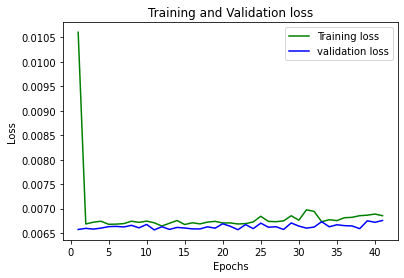

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,42)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

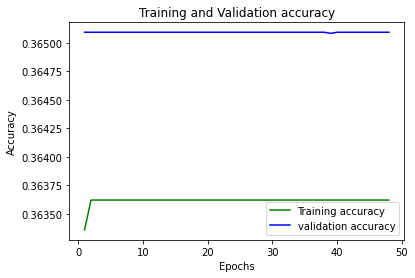

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,49)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
NN_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                338       
                                                                 
 dense_1 (Dense)             (None, 1)                 14        
                                                                 
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
